In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchinfo

In [3]:
from torchvision.io.image import read_image
from torchvision.models.detection import fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

# Load the image
img = read_image("/content/drive/MyDrive/data/2DB/training/images/AGS_DA_00C_BA_22090202_000471.jpg")

# Step 1: Initialize model with the best available weights
weights = FCOS_ResNet50_FPN_Weights.DEFAULT
model = fcos_resnet50_fpn(weights=weights, box_score_thresh=0.9)
model.eval()
# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()


Downloading: "https://download.pytorch.org/models/fcos_resnet50_fpn_coco-99b0c9b7.pth" to /root/.cache/torch/hub/checkpoints/fcos_resnet50_fpn_coco-99b0c9b7.pth
100%|██████████| 124M/124M [00:07<00:00, 16.8MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/utils.py:232: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


In [4]:
import torch
from torchvision.models.detection import fcos_resnet50_fpn

# Initialize the model
model = fcos_resnet50_fpn(num_classes=10)

# Sample input
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400), torch.rand(3, 600, 350)]

print("Before forward pass:")
for image in x:
    print(image.shape)

model.eval()
predictions = model(x)

print("\nAfter forward pass:")
for pred in predictions:
    print("Boxes:", pred["boxes"].shape)
    print("Labels:", pred["labels"].shape)
    print("Scores:", pred["scores"].shape)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 70.3MB/s]


Before forward pass:
torch.Size([3, 300, 400])
torch.Size([3, 500, 400])
torch.Size([3, 600, 350])

After forward pass:
Boxes: torch.Size([25, 4])
Labels: torch.Size([25])
Scores: torch.Size([25])
Boxes: torch.Size([89, 4])
Labels: torch.Size([89])
Scores: torch.Size([89])
Boxes: torch.Size([12, 4])
Labels: torch.Size([12])
Scores: torch.Size([12])


Loading Images: 100%|██████████| 800/800 [00:00<00:00, 1269558.53it/s]


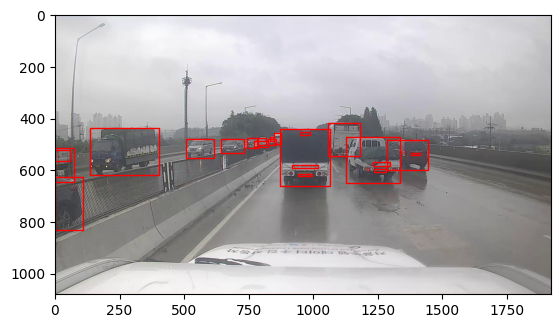

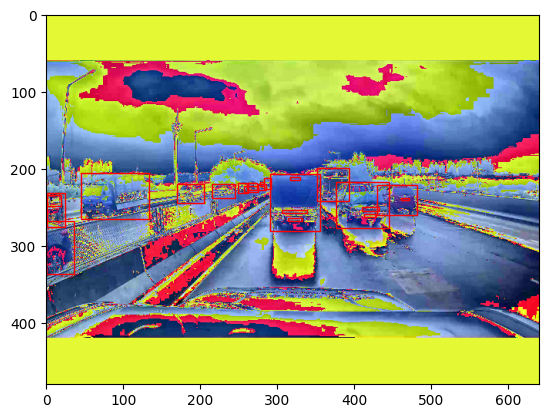

In [23]:
import os
import json
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision.transforms import functional as F
from PIL import ImageDraw

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CustomDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")

        self.image_files = sorted([f for f in tqdm(os.listdir(self.image_dir), desc="Loading Images") if f.endswith('.jpg')])

        self.label_map = {
            "none": 0,
            "car": 1,
            "truck": 2,
            "bus": 3,
            "special_vehicle": 4,
            "motorcycle": 5,
            "bicycle": 6,
            "pedestrian": 7,
            "traffic_sign": 8,
            "traffic_light": 9
        }

        self.transform = transforms.Compose([
            transforms.Resize((360, 640)),
            transforms.Pad((0, 60, 0, 60)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = img_path.replace("images", "labels").replace(".jpg", ".json")

        orig_image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = orig_image.size

        image = self.transform(orig_image)

        with open(label_path, 'r') as file:
            label_data = json.load(file)

        boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
        labels = [anno['Label'] for anno in label_data['Annotation']]

        # Adjust bounding boxes after resize
        width_ratio = 640 / orig_width
        height_ratio = 360 / orig_height

        # 변환 전: [x_min, y_min, width, height]
        # 변환 후: [x1, y1, x2, y2]

        boxes = [[box[0] * width_ratio,
            box[1] * height_ratio + 60,
            (box[0] + box[2]) * width_ratio,
            (box[1] + box[3]) * height_ratio + 60] for box in boxes]


        # Convert string labels to integer labels
        labels = [self.label_map[label] for label in labels]

        # Return transformed image and labels
        sample = {
            'orig_data': orig_image,
            'data': image,
            'labels': {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64)
            }
        }

        return sample

    def revert_transforms(self, boxes, orig_width, orig_height):
        """원래 이미지 크기로 바운딩 박스 좌표 변환"""
        width_ratio = orig_width / 640
        height_ratio = orig_height / 360
        boxes = [[box[0] * width_ratio,
          (box[1] - 60) * height_ratio,
          box[2] * width_ratio,
          (box[3] - 60) * height_ratio] for box in boxes]

        return boxes

def plot_image_with_boxes(image, boxes, labels=None):
    """이미지에 바운딩 박스를 표시합니다."""
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box in boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()



# 사용 예시:
dataset = CustomDataset("/content/drive/MyDrive/data/2DB/training")
sample = dataset[100]

# 원래 이미지에 바운딩 박스 치기
reverted_boxes = dataset.revert_transforms(sample['labels']['boxes'].tolist(), *sample['orig_data'].size)
plot_image_with_boxes(sample['orig_data'], reverted_boxes, sample['labels']['labels'].tolist())

# 잘린 이미지에 바운딩 박스 치기
plot_image_with_boxes(transforms.functional.to_pil_image(sample['data']), sample['labels']['boxes'].tolist(), sample['labels']['labels'].tolist())


In [24]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    data = [item['data'] for item in batch]
    labels = [item['labels'] for item in batch]
    return {'data': data, 'labels': labels}

train_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/training")
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/validation")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

test_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/test")
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

Loading Images: 100%|██████████| 100/100 [00:00<00:00, 671088.64it/s]


In [25]:
import torch
import torch.nn as nn
from torchvision.models.detection import fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights

# 1. Instantiate the model
model = fcos_resnet50_fpn(weights=FCOS_ResNet50_FPN_Weights.DEFAULT).to(device)

# 2. Modify the FCOSClassificationHead's last layer
classification_head = model.head.classification_head
in_channels = 256  # Using this value as the base for additional layers
num_classes = 10

# Replacing with a simpler cls_logits layer
classification_head.cls_logits = nn.Conv2d(in_channels, classification_head.num_anchors * num_classes, kernel_size=3, stride=1, padding=1)

# Adjust the num_classes attribute in the model and its classification head
model.num_classes = num_classes
classification_head.num_classes = num_classes

# # Defining additional layers
# additional_layers = [
#     nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
#     nn.GroupNorm(32, in_channels),
#     nn.ReLU()
# ]

In [32]:
import torch.optim as optim

# 1. 손실 함수와 옵티마이저 정의
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# 2. 학습 함수와 평가 함수 정의
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    for batch in tqdm(data_loader):
        images = [img.to(device) for img in batch['data']]
        targets = [{k: v.to(device) for k, v in label.items()} for label in batch['labels']]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

def evaluate(model, data_loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            images = [img.to(device) for img in batch['data']]
            targets = [{k: v.to(device) for k, v in label.items()} for label in batch['labels']]
            # 모델 예측
            outputs = model(images)
    return results

In [34]:
# Transfer Learning: Training the head only...
print("Transfer Learning: Training the head only...")
for param in model.backbone.parameters():
    param.requires_grad = False

num_epochs_transfer = 5
for epoch in range(num_epochs_transfer):
    print(f"Epoch {epoch+1}/{num_epochs_transfer}")
    train_one_epoch(model.to(device), optimizer, train_loader, device)
    results = evaluate(model.to(device), val_loader, device)

# Fine-tuning
print("\nFine-tuning: Training the entire model...")
for param in model.parameters():
    param.requires_grad = True

num_epochs_fine_tuning = 10
for epoch in range(num_epochs_fine_tuning):
    print(f"Epoch {epoch+1}/{num_epochs_fine_tuning}")
    train_one_epoch(model, optimizer, train_loader, device)
    results = evaluate(model, val_loader, device)


Transfer Learning: Training the head only...
Epoch 1/5


100%|██████████| 25/25 [00:32<00:00,  1.29s/it]


Epoch 2/5


100%|██████████| 25/25 [00:04<00:00,  5.73it/s]


Epoch 3/5


100%|██████████| 25/25 [00:04<00:00,  5.87it/s]


Epoch 4/5


100%|██████████| 25/25 [00:04<00:00,  5.89it/s]


Epoch 5/5


100%|██████████| 25/25 [00:04<00:00,  5.92it/s]



Fine-tuning: Training the entire model...
Epoch 1/10


100%|██████████| 25/25 [00:04<00:00,  5.80it/s]


Epoch 2/10


100%|██████████| 25/25 [00:04<00:00,  5.88it/s]


Epoch 3/10


100%|██████████| 25/25 [00:04<00:00,  5.89it/s]


Epoch 4/10


100%|██████████| 25/25 [00:04<00:00,  5.91it/s]


Epoch 5/10


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]


Epoch 6/10


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


Epoch 7/10


100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


Epoch 8/10


100%|██████████| 25/25 [00:04<00:00,  6.02it/s]


Epoch 9/10


100%|██████████| 25/25 [00:04<00:00,  5.90it/s]


Epoch 10/10


100%|██████████| 25/25 [00:04<00:00,  5.95it/s]


In [45]:
# Set the model back to evaluation mode
model.eval()

# Initialize variables to track correct predictions and total samples
correct_predictions = 0
total_samples = 0

# Iterate through the test dataset
with torch.no_grad():
    for batch in tqdm(test_loader):
        images = [img.to(device) for img in batch['data']]
        targets = [{k: v.to(device) for k, v in label.items()} for label in batch['labels']]
        print(outputs)
        # Forward pass
        outputs = model(images)
        # Calculate accuracy
        for output, target in zip(outputs, targets):
            # Assuming your model's output provides class probabilities
            predicted_probs = output['scores']
            true_classes = target['labels']

            # Convert predicted probabilities to class indices
            predicted_classes = torch.argmax(predicted_probs, dim=-1)

            # Calculate the number of correct predictions in the batch
            correct_predictions += torch.sum(predicted_classes == true_classes).item()
            total_samples += len(true_classes)

# Calculate and print accuracy
accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {accuracy:.2%}")


  0%|          | 0/25 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78ff65fa5e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78ff65fa5e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers


[{'boxes': tensor([[151.7484, 226.2328, 244.2706, 286.9074],
        [486.6628, 226.5021, 640.0000, 399.6322],
        [301.9317, 227.7314, 366.4502, 282.4260],
        [240.8497, 223.8347, 280.7352, 250.9287],
        [322.6912, 218.5130, 346.3618, 232.6476],
        [138.6308, 218.5691, 172.5810, 238.5194],
        [275.0682, 214.3434, 300.3788, 239.0217],
        [363.9950, 189.6854, 414.1494, 242.3764],
        [161.0507, 217.3831, 186.5080, 230.0222],
        [388.2511, 218.4254, 459.3084, 275.2421],
        [565.8954, 248.3172, 604.3236, 271.4515],
        [220.8904, 217.2961, 234.3925, 226.9094],
        [565.8954, 248.3172, 604.3236, 271.4515],
        [275.4925, 214.3404, 300.5331, 238.9304],
        [387.2656, 218.1501, 458.5751, 273.2952],
        [133.8508, 217.8838, 145.8257, 225.8586],
        [300.7647, 228.6727, 367.1346, 286.5505],
        [345.3153, 212.8708, 356.9221, 224.2036],
        [300.5466, 211.3738, 314.8807, 231.6592],
        [150.7355, 218.3280, 186.1021, 

    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78ff65fa5e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  8%|▊         | 2/25 [00:01<00:10,  2.10it/s]

[{'boxes': tensor([[230.8690, 217.6983, 275.6628, 251.1978],
        [608.3705, 220.3922, 629.0986, 231.8963],
        [278.9938, 220.1132, 296.4883, 231.7371],
        [570.3500, 216.0216, 586.9429, 227.5261],
        [413.7906, 209.7924, 439.2423, 233.4592],
        [429.3022, 203.6350, 462.1754, 223.6417],
        [372.9455, 210.1521, 400.4268, 236.5948],
        [353.8409, 216.4687, 370.5782, 228.4406],
        [230.8690, 217.6983, 275.6628, 251.1978],
        [352.2336, 215.1743, 363.1834, 225.3501],
        [278.9938, 220.1132, 296.4883, 231.7371],
        [524.3765, 214.0997, 538.0682, 223.4173],
        [496.7532, 215.4348, 509.7679, 222.5942],
        [429.3022, 203.6350, 462.1754, 223.6417],
        [608.3705, 220.3922, 629.0986, 231.8963],
        [316.3729, 217.9401, 324.0551, 223.9472],
        [336.0871, 216.9644, 343.6269, 222.8533],
        [299.1457, 203.3549, 306.7897, 208.7786],
        [570.3500, 216.0216, 586.9429, 227.5261],
        [372.9455, 210.1521, 400.4268, 

 16%|█▌        | 4/25 [00:01<00:06,  3.33it/s]

[{'boxes': tensor([[8.9810e-02, 2.8523e+02, 1.2176e+02, 3.9891e+02],
        [3.2353e+02, 2.2108e+02, 3.4665e+02, 2.4055e+02],
        [2.8880e+02, 2.2251e+02, 3.1070e+02, 2.3701e+02],
        [0.0000e+00, 3.0066e+02, 7.4099e+01, 3.8681e+02],
        [0.0000e+00, 2.8596e+02, 1.2715e+02, 3.9756e+02],
        [3.2353e+02, 2.2108e+02, 3.4665e+02, 2.4055e+02],
        [2.8880e+02, 2.2251e+02, 3.1070e+02, 2.3701e+02],
        [0.0000e+00, 3.0066e+02, 7.4099e+01, 3.8681e+02],
        [3.3096e+02, 2.1787e+02, 3.4291e+02, 2.2379e+02],
        [0.0000e+00, 2.8596e+02, 1.2715e+02, 3.9756e+02],
        [3.2353e+02, 2.2108e+02, 3.4665e+02, 2.4055e+02],
        [0.0000e+00, 2.8596e+02, 1.2715e+02, 3.9756e+02],
        [2.8880e+02, 2.2251e+02, 3.1070e+02, 2.3701e+02],
        [0.0000e+00, 3.0066e+02, 7.4099e+01, 3.8681e+02],
        [3.2353e+02, 2.2108e+02, 3.4665e+02, 2.4055e+02],
        [3.8642e+00, 2.8370e+02, 1.9488e+02, 3.9782e+02],
        [0.0000e+00, 3.0066e+02, 7.4099e+01, 3.8681e+02],
   

 20%|██        | 5/25 [00:01<00:05,  3.70it/s]

[{'boxes': tensor([[1.3762e-01, 2.4446e+02, 3.2105e+01, 2.8414e+02],
        [1.7559e+02, 2.2043e+02, 2.0708e+02, 2.4188e+02],
        [3.6958e+02, 2.2400e+02, 4.0611e+02, 2.5040e+02],
        [2.5309e+02, 2.1676e+02, 2.7867e+02, 2.3243e+02],
        [2.7229e+02, 2.2014e+02, 2.8784e+02, 2.3178e+02],
        [3.4954e+02, 2.1529e+02, 3.6676e+02, 2.3428e+02],
        [3.8137e+02, 1.9765e+02, 4.2373e+02, 2.3647e+02],
        [3.0264e+02, 2.0897e+02, 3.5042e+02, 2.6500e+02],
        [4.9826e+02, 9.4696e+01, 6.3993e+02, 3.9355e+02],
        [2.0948e+02, 2.0914e+02, 2.4260e+02, 2.3983e+02],
        [8.6574e+01, 2.1389e+02, 1.4979e+02, 2.5500e+02],
        [2.3807e+02, 2.1861e+02, 2.5262e+02, 2.3359e+02],
        [2.4590e+02, 2.1854e+02, 2.7518e+02, 2.3419e+02],
        [4.9672e+02, 2.2248e+02, 5.1102e+02, 2.5083e+02],
        [4.9861e+02, 1.9884e+02, 6.3873e+02, 3.8613e+02],
        [2.0948e+02, 2.0914e+02, 2.4260e+02, 2.3983e+02],
        [3.0163e+02, 2.0761e+02, 3.5058e+02, 2.6808e+02],
   

 24%|██▍       | 6/25 [00:02<00:05,  3.20it/s]

[{'boxes': tensor([[0.0000e+00, 2.4922e+02, 2.0759e+02, 3.7273e+02],
        [4.6433e+02, 2.6415e+02, 6.3873e+02, 3.8612e+02],
        [1.9710e+02, 2.2784e+02, 2.5358e+02, 2.7453e+02],
        [4.1442e+02, 2.3090e+02, 4.4482e+02, 2.7430e+02],
        [4.3506e+02, 2.2297e+02, 4.8892e+02, 2.6136e+02],
        [4.7585e+02, 2.3230e+02, 5.5668e+02, 2.8053e+02],
        [2.1521e+02, 2.2170e+02, 2.3607e+02, 2.3061e+02],
        [8.0447e+00, 3.1826e+02, 3.7004e+01, 3.3373e+02],
        [3.1933e+02, 2.7488e+02, 3.5075e+02, 2.9258e+02],
        [3.1933e+02, 2.7488e+02, 3.5075e+02, 2.9258e+02],
        [2.4982e+02, 8.2481e+01, 4.2133e+02, 3.3337e+02],
        [8.0447e+00, 3.1826e+02, 3.7004e+01, 3.3373e+02],
        [5.6309e-01, 2.1422e+02, 2.3121e+01, 2.2930e+02],
        [5.6309e-01, 2.1422e+02, 2.3121e+01, 2.2930e+02],
        [5.0260e+02, 2.4267e+02, 5.5714e+02, 2.7797e+02],
        [2.4954e+02, 7.6283e+01, 4.2019e+02, 3.3459e+02],
        [4.6433e+02, 2.6415e+02, 6.3873e+02, 3.8612e+02],
   

 28%|██▊       | 7/25 [00:02<00:05,  3.56it/s]

[{'boxes': tensor([[363.1644, 220.1050, 473.9629, 265.5616],
        [571.9632, 247.5857, 639.3011, 398.6573],
        [488.2671, 231.4169, 512.8095, 304.7568],
        [487.8856, 236.8436, 511.2138, 304.4956],
        [458.4839, 220.9709, 481.6856, 278.5834],
        [487.8856, 236.8436, 511.2138, 304.4956],
        [488.2671, 231.4169, 512.8095, 304.7568],
        [571.9632, 247.5857, 639.3011, 398.6573],
        [363.1644, 220.1050, 473.9629, 265.5616],
        [457.5383, 221.6645, 482.6617, 276.9004],
        [457.5383, 221.6645, 482.6617, 276.9004],
        [457.5383, 221.6645, 482.6617, 276.9004],
        [460.1400, 221.4911, 479.4822, 258.5096],
        [487.8856, 236.8436, 511.2138, 304.4956],
        [488.2671, 231.4169, 512.8095, 304.7568],
        [419.8221, 217.1658, 482.7715, 269.8221],
        [491.3181, 232.4562, 503.2482, 261.8198],
        [488.8246, 232.8314, 503.3380, 284.8138],
        [488.5215, 250.2258, 507.2961, 297.9244],
        [457.5383, 221.6645, 482.6617, 

 36%|███▌      | 9/25 [00:02<00:03,  4.23it/s]

[{'boxes': tensor([[591.2985, 325.5157, 639.4257, 398.7709],
        [306.8228, 220.8766, 342.9815, 239.0363],
        [400.6664, 234.0236, 494.6492, 289.7018],
        [353.6789, 222.3472, 383.1687, 243.3064],
        [279.4292, 237.7289, 365.0851, 306.5014],
        [348.1766, 217.1547, 365.0470, 235.5449],
        [334.2848, 208.1441, 352.7635, 229.1247],
        [348.1766, 217.1547, 365.0470, 235.5449],
        [306.8228, 220.8766, 342.9815, 239.0363],
        [400.6664, 234.0236, 494.6492, 289.7018],
        [591.2985, 325.5157, 639.4257, 398.7709],
        [353.6789, 222.3472, 383.1687, 243.3064],
        [608.5674, 329.8529, 640.0000, 391.5981],
        [331.3809, 220.1497, 346.0829, 236.4696],
        [279.4292, 237.7289, 365.0851, 306.5014],
        [303.7459, 222.5394, 344.6429, 246.2333],
        [334.8984, 208.7638, 352.4170, 230.7147],
        [317.0925, 216.4264, 331.3593, 222.0692],
        [308.8921, 271.9978, 335.4201, 277.6631],
        [308.8921, 271.9978, 335.4201, 

 40%|████      | 10/25 [00:02<00:03,  4.42it/s]

[{'boxes': tensor([[2.6865e+02, 2.2594e+02, 3.8287e+02, 3.3060e+02],
        [3.7793e+02, 2.2974e+02, 4.3923e+02, 2.6967e+02],
        [2.4892e+02, 2.2190e+02, 2.8573e+02, 2.5055e+02],
        [2.7245e+02, 2.1752e+02, 2.9414e+02, 2.3491e+02],
        [1.2430e+02, 2.2317e+02, 1.4581e+02, 2.3535e+02],
        [2.0668e+02, 2.1920e+02, 2.3271e+02, 2.3530e+02],
        [2.3894e+02, 2.1696e+02, 2.6015e+02, 2.3646e+02],
        [3.4945e+02, 9.8651e+01, 3.9721e+02, 1.3161e+02],
        [3.4991e+02, 9.5170e+01, 4.7545e+02, 1.3813e+02],
        [1.2547e+02, 2.1359e+02, 1.4499e+02, 2.2732e+02],
        [3.4945e+02, 9.8651e+01, 3.9721e+02, 1.3161e+02],
        [3.0211e+02, 2.2045e+02, 3.3794e+02, 2.2922e+02],
        [2.8740e+02, 2.1357e+02, 3.0227e+02, 2.2870e+02],
        [3.4991e+02, 9.5170e+01, 4.7545e+02, 1.3813e+02],
        [3.3704e+02, 2.1783e+02, 3.5121e+02, 2.2484e+02],
        [0.0000e+00, 2.0732e+02, 7.1140e+01, 2.6638e+02],
        [3.1274e+02, 2.1355e+02, 3.3069e+02, 2.2168e+02],
   

 48%|████▊     | 12/25 [00:03<00:02,  4.66it/s]

[{'boxes': tensor([[  0.0000, 234.0134,  67.3571, 305.5823],
        [414.8058, 219.4854, 449.9027, 238.6447],
        [  0.0000, 234.0134,  67.3571, 305.5823],
        [340.1985, 216.6752, 349.8842, 224.4038],
        [414.8058, 219.4854, 449.9027, 238.6447],
        [399.7357, 220.5972, 413.3274, 229.4146],
        [330.4983, 215.4287, 339.9638, 223.5210],
        [344.9626, 217.1381, 352.5659, 224.4870],
        [340.1985, 216.6752, 349.8842, 224.4038],
        [414.9533, 221.2979, 438.9011, 236.0538],
        [372.8387, 193.8968, 384.7296, 198.7536],
        [372.8387, 193.8968, 384.7296, 198.7536],
        [  0.0000, 234.0134,  67.3571, 305.5823],
        [405.3551, 220.5546, 415.7943, 228.8843],
        [618.2838, 194.5654, 638.7241, 225.9457],
        [330.4983, 215.4287, 339.9638, 223.5210],
        [414.8058, 219.4854, 449.9027, 238.6447],
        [228.4849, 218.7032, 238.7298, 236.2026],
        [618.2838, 194.5654, 638.7241, 225.9457],
        [  0.0000, 234.0134,  67.3571, 

 56%|█████▌    | 14/25 [00:03<00:02,  4.93it/s]

[{'boxes': tensor([[446.4362, 249.9612, 631.1259, 353.0928],
        [260.0273, 168.8928, 289.3078, 188.3343],
        [260.0273, 168.8928, 289.3078, 188.3343],
        [446.4362, 249.9612, 631.1259, 353.0928],
        [260.0273, 168.8928, 289.3078, 188.3343],
        [273.4912, 163.7454, 289.2082, 170.8251],
        [260.0273, 168.8928, 289.3078, 188.3343],
        [273.4912, 163.7454, 289.2082, 170.8251],
        [260.0273, 168.8928, 289.3078, 188.3343],
        [446.4362, 249.9612, 631.1259, 353.0928],
        [446.4362, 249.9612, 631.1259, 353.0928],
        [273.4912, 163.7454, 289.2082, 170.8251],
        [273.4912, 163.7454, 289.2082, 170.8251],
        [264.3152, 166.6177, 295.4917, 184.3398],
        [260.3112, 158.5945, 272.5876, 169.4187],
        [446.4362, 249.9612, 631.1259, 353.0928],
        [264.3152, 166.6177, 295.4917, 184.3398],
        [273.4912, 163.7454, 289.2082, 170.8251],
        [260.3112, 158.5945, 272.5876, 169.4187],
        [260.0273, 168.8928, 289.3078, 

 60%|██████    | 15/25 [00:03<00:02,  4.85it/s]

[{'boxes': tensor([[  0.0000, 293.3803,  73.5495, 392.7649],
        [355.8249, 212.0417, 388.3610, 237.9642],
        [ 49.3743, 156.8971,  89.1488, 184.3436],
        [ 49.3743, 156.8971,  89.1488, 184.3436],
        [355.8249, 212.0417, 388.3610, 237.9642],
        [  0.0000, 293.3803,  73.5495, 392.7649],
        [147.3936, 247.8351, 189.3429, 279.9066],
        [ 49.3743, 156.8971,  89.1488, 184.3436],
        [344.3377, 211.5165, 361.6816, 226.1414],
        [344.3377, 211.5165, 361.6816, 226.1414],
        [ 50.1435, 155.4795, 103.8727, 191.5589],
        [355.8249, 212.0417, 388.3610, 237.9642],
        [ 50.1435, 155.4795, 103.8727, 191.5589],
        [ 49.3743, 156.8971,  89.1488, 184.3436],
        [  0.0000, 293.3803,  73.5495, 392.7649],
        [355.8249, 212.0417, 388.3610, 237.9642],
        [283.2242, 237.7177, 291.5177, 251.3082],
        [ 49.3743, 156.8971,  89.1488, 184.3436],
        [283.2242, 237.7177, 291.5177, 251.3082],
        [147.3936, 247.8351, 189.3429, 

 68%|██████▊   | 17/25 [00:04<00:01,  4.90it/s]

[{'boxes': tensor([[279.7731, 220.6615, 306.7512, 239.0891],
        [329.2254, 216.5495, 340.1201, 226.2742],
        [321.9363, 217.2472, 329.7440, 224.4695],
        [279.7731, 220.6615, 306.7512, 239.0891],
        [111.3464, 220.8828, 138.8890, 240.7872],
        [329.2254, 216.5495, 340.1201, 226.2742],
        [314.7401, 218.5799, 322.2556, 224.8802],
        [111.3464, 220.8828, 138.8890, 240.7872],
        [308.9077, 219.3033, 315.8159, 225.6151],
        [279.7731, 220.6615, 306.7512, 239.0891],
        [321.9363, 217.2472, 329.7440, 224.4695],
        [323.2649, 213.2497, 330.1033, 220.3281],
        [293.1397, 216.6203, 312.8304, 227.1440],
        [329.2254, 216.5495, 340.1201, 226.2742],
        [279.7731, 220.6615, 306.7512, 239.0891],
        [301.4780, 221.2353, 313.0613, 234.1262],
        [306.0347, 220.5202, 314.2738, 227.1610],
        [329.2254, 216.5495, 340.1201, 226.2742],
        [342.6816, 216.6268, 350.3540, 222.7866],
        [314.7401, 218.5799, 322.2556, 

 72%|███████▏  | 18/25 [00:04<00:01,  4.84it/s]

[{'boxes': tensor([[5.2577e-01, 3.1565e+02, 5.5157e+01, 3.9346e+02],
        [2.1227e+02, 1.8421e+02, 2.9597e+02, 2.5795e+02],
        [1.1993e+02, 2.2604e+02, 1.6729e+02, 2.3861e+02],
        [2.9477e+02, 1.6643e+02, 3.6804e+02, 2.7171e+02],
        [1.6569e+02, 2.0970e+02, 1.9829e+02, 2.3031e+02],
        [1.6569e+02, 2.0970e+02, 1.9829e+02, 2.3031e+02],
        [2.1278e+02, 1.8463e+02, 2.9599e+02, 2.5780e+02],
        [2.2569e+02, 2.0262e+02, 2.5900e+02, 2.0974e+02],
        [2.9477e+02, 1.6643e+02, 3.6804e+02, 2.7171e+02],
        [2.2569e+02, 2.0262e+02, 2.5900e+02, 2.0974e+02],
        [3.8980e+02, 2.1158e+02, 4.1539e+02, 2.2363e+02],
        [2.2406e+02, 2.1824e+02, 2.5941e+02, 2.3960e+02],
        [5.2577e-01, 3.1565e+02, 5.5157e+01, 3.9346e+02],
        [2.9477e+02, 1.6643e+02, 3.6804e+02, 2.7171e+02],
        [2.2406e+02, 2.1824e+02, 2.5941e+02, 2.3960e+02],
        [2.9477e+02, 1.6643e+02, 3.6804e+02, 2.7171e+02],
        [0.0000e+00, 3.2484e+02, 3.4211e+01, 3.8293e+02],
   

 76%|███████▌  | 19/25 [00:04<00:01,  4.81it/s]

[{'boxes': tensor([[137.5950, 232.2066, 243.0229, 298.2145],
        [241.1069, 222.6754, 285.7804, 252.3435],
        [ 24.5083, 229.2134,  88.2746, 246.9271],
        [284.4332, 218.0954, 304.7773, 235.3274],
        [308.6669, 216.4177, 318.1821, 226.1424],
        [323.4185, 187.9838, 364.1788, 247.2198],
        [225.0946, 215.7371, 243.9411, 225.7286],
        [125.5973, 214.4769, 171.7054, 234.4715],
        [323.3862, 186.8107, 364.4667, 246.4755],
        [296.3888, 216.9819, 308.9969, 230.4786],
        [125.5973, 214.4769, 171.7054, 234.4715],
        [284.7466, 210.4724, 297.8824, 221.2100],
        [225.0946, 215.7371, 243.9411, 225.7286],
        [137.5950, 232.2066, 243.0229, 298.2145],
        [241.1069, 222.6754, 285.7804, 252.3435],
        [284.7466, 210.4724, 297.8824, 221.2100],
        [  0.0000,  81.9072,  85.0848, 155.5668],
        [  0.0000,  82.6137,  84.9992, 156.7011],
        [300.5588, 217.4911, 310.0285, 229.3991],
        [ 20.4473, 229.9245,  88.0868, 

 80%|████████  | 20/25 [00:04<00:01,  4.82it/s]

[{'boxes': tensor([[4.1550e+02, 2.2186e+02, 4.4114e+02, 2.4003e+02],
        [4.1550e+02, 2.2186e+02, 4.4114e+02, 2.4003e+02],
        [3.4928e+02, 2.1782e+02, 3.5792e+02, 2.2492e+02],
        [3.4928e+02, 2.1782e+02, 3.5792e+02, 2.2492e+02],
        [3.3072e+02, 2.1716e+02, 3.3850e+02, 2.2286e+02],
        [4.1550e+02, 2.2186e+02, 4.4114e+02, 2.4003e+02],
        [6.7888e+01, 2.2731e+02, 7.6125e+01, 2.4709e+02],
        [1.9239e+02, 2.0356e+02, 2.0494e+02, 2.1951e+02],
        [4.1550e+02, 2.2186e+02, 4.4114e+02, 2.4003e+02],
        [5.2146e+02, 2.1119e+02, 5.3795e+02, 2.1998e+02],
        [3.3072e+02, 2.1716e+02, 3.3850e+02, 2.2286e+02],
        [1.9239e+02, 2.0356e+02, 2.0494e+02, 2.1951e+02],
        [6.8003e+01, 2.2687e+02, 7.6093e+01, 2.4643e+02],
        [1.3553e+02, 2.0718e+02, 1.4687e+02, 2.1678e+02],
        [4.1550e+02, 2.2186e+02, 4.4114e+02, 2.4003e+02],
        [5.2146e+02, 2.1119e+02, 5.3795e+02, 2.1998e+02],
        [5.2146e+02, 2.1119e+02, 5.3795e+02, 2.1998e+02],
   

 88%|████████▊ | 22/25 [00:05<00:00,  4.98it/s]

[{'boxes': tensor([[304.9007, 236.0018, 388.4839, 304.8347],
        [  0.0000, 246.9648, 217.3418, 397.9265],
        [268.4368, 220.3693, 310.5540, 249.9850],
        [303.7390, 224.2120, 343.7482, 254.1683],
        [330.2984, 217.3074, 347.5389, 233.3667],
        [395.6472, 205.9652, 409.0601, 217.7072],
        [313.4338, 222.8805, 350.6426, 248.2173],
        [315.6584, 214.2708, 327.1846, 224.4200],
        [304.9007, 236.0018, 388.4839, 304.8347],
        [268.4368, 220.3693, 310.5540, 249.9850],
        [  0.0000, 246.9648, 217.3418, 397.9265],
        [315.6584, 214.2708, 327.1846, 224.4200],
        [395.6472, 205.9652, 409.0601, 217.7072],
        [303.7390, 224.2120, 343.7482, 254.1683],
        [330.3895, 217.4243, 348.1451, 234.3363],
        [289.4605, 222.8825, 312.4870, 253.3045],
        [324.4047, 208.8729, 337.5263, 220.7840],
        [268.4368, 220.3693, 310.5540, 249.9850],
        [ 79.5939, 247.1472, 216.7740, 379.1849],
        [304.9007, 236.0018, 388.4839, 

 92%|█████████▏| 23/25 [00:05<00:00,  4.87it/s]

[{'boxes': tensor([[491.7645, 222.3973, 540.5446, 252.7977],
        [236.0900, 217.1688, 269.3392, 240.0906],
        [315.5717, 219.7007, 328.8885, 228.8515],
        [405.3781, 217.7696, 420.4781, 229.0176],
        [386.3878, 191.3986, 400.6428, 203.2131],
        [105.1058, 219.8942, 150.4727, 232.5483],
        [471.0575, 145.8043, 498.1876, 164.5639],
        [296.7441, 217.3878, 307.0261, 224.6424],
        [386.3878, 191.3986, 400.6428, 203.2131],
        [236.0900, 217.1688, 269.3392, 240.0906],
        [471.0575, 145.8043, 498.1876, 164.5639],
        [491.7645, 222.3973, 540.5446, 252.7977],
        [230.1127, 216.8434, 241.8666, 222.0406],
        [315.5717, 219.7007, 328.8885, 228.8515],
        [358.8527, 216.8014, 371.8633, 228.6659],
        [405.3781, 217.7696, 420.4781, 229.0176],
        [358.4327, 216.6337, 369.2138, 224.9064],
        [317.2512, 209.7738, 328.8320, 220.1154],
        [234.9986, 216.4248, 263.5071, 234.5258],
        [268.1646, 215.4316, 283.9889, 

100%|██████████| 25/25 [00:05<00:00,  5.01it/s]

[{'boxes': tensor([[0.0000e+00, 2.9290e+02, 7.6025e+01, 3.8695e+02],
        [1.5621e+02, 2.1511e+02, 1.7896e+02, 2.3650e+02],
        [3.1706e+00, 2.0962e+02, 5.5137e+01, 2.3570e+02],
        [3.1706e+00, 2.0962e+02, 5.5137e+01, 2.3570e+02],
        [2.0583e+02, 2.2110e+02, 2.1980e+02, 2.3126e+02],
        [1.5621e+02, 2.1511e+02, 1.7896e+02, 2.3650e+02],
        [0.0000e+00, 2.9290e+02, 7.6025e+01, 3.8695e+02],
        [1.5621e+02, 2.1511e+02, 1.7896e+02, 2.3650e+02],
        [1.5621e+02, 2.1511e+02, 1.7896e+02, 2.3650e+02],
        [1.5621e+02, 2.1511e+02, 1.7896e+02, 2.3650e+02],
        [1.5621e+02, 2.1511e+02, 1.7896e+02, 2.3650e+02],
        [2.2398e+01, 2.1124e+02, 5.3778e+01, 2.3516e+02],
        [2.0583e+02, 2.2110e+02, 2.1980e+02, 2.3126e+02],
        [3.1706e+00, 2.0962e+02, 5.5137e+01, 2.3570e+02],
        [1.5621e+02, 2.1511e+02, 1.7896e+02, 2.3650e+02],
        [1.3615e+02, 2.2073e+02, 1.4879e+02, 2.3042e+02],
        [3.1706e+00, 2.0962e+02, 5.5137e+01, 2.3570e+02],
   

100%|██████████| 25/25 [00:06<00:00,  4.14it/s]

Test Accuracy: 10.21%


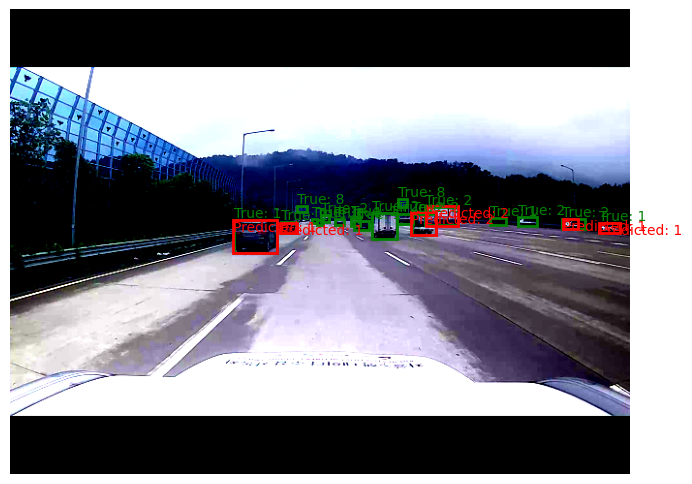

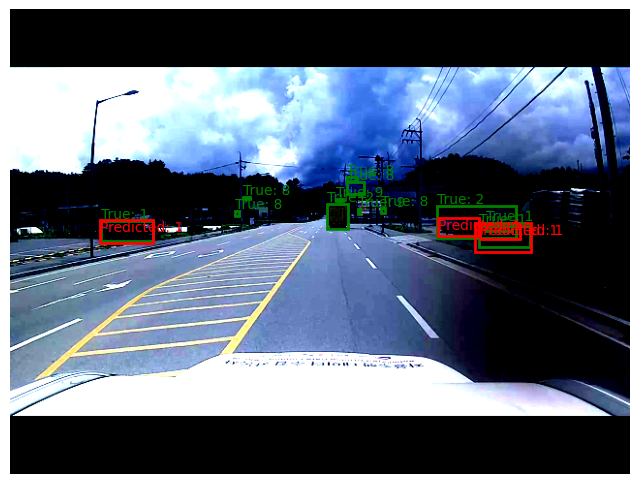

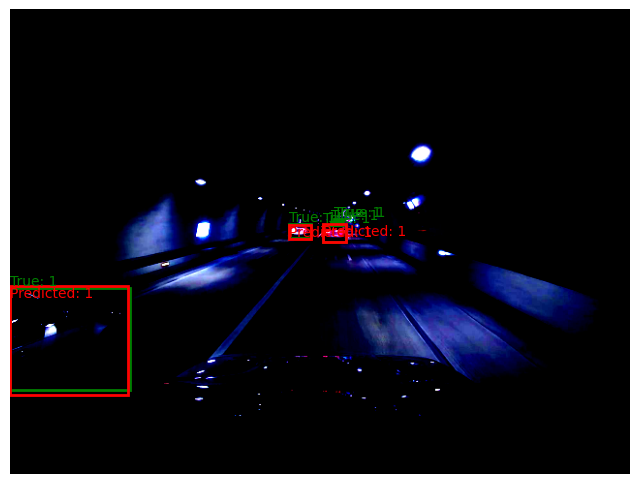

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Select a few samples from the test dataset
num_samples_to_visualize = 3
visualization_samples = []
for i, batch in enumerate(test_loader):
    if i >= num_samples_to_visualize:
        break
    visualization_samples.append(batch)

# Iterate through selected samples
for i, batch in enumerate(visualization_samples):
    image = batch['data'][0].cpu().numpy().transpose(1, 2, 0)
    true_boxes = batch['labels'][0]['boxes'].cpu().numpy()
    true_labels = batch['labels'][0]['labels'].cpu().numpy()

    outputs = model([batch['data'][0].to(device)])
    predicted_boxes = outputs[0]['boxes'].cpu().detach().numpy()
    predicted_labels = outputs[0]['labels'].cpu().detach().numpy()
    predicted_scores = outputs[0]['scores'].cpu().detach().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(image)

    # Plot true boxes
    for box, label in zip(true_boxes, true_labels):
        box = [int(coord) for coord in box]
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(box[0], box[1], f"True: {label}", color='g', verticalalignment='bottom')

    # Plot predicted boxes with highest confidence
    for box, label, score in zip(predicted_boxes, predicted_labels, predicted_scores):
        if score > 0.5:  # Adjust the confidence threshold as needed
            box = [int(coord) for coord in box]
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(box[0], box[1], f"Predicted: {label}", color='r', verticalalignment='top')

    plt.axis('off')
    plt.show()
